##### Copyright 2021 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFP Release Notes notebook (0.13.0)

The intent of this notebook is to help TFP 0.13.0 "come to life" via some small snippets - little demos of things you can achieve with TFP.


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/TFP_Release_Notebook_0_13_0"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/TFP_Release_Notebook_0_13_0.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/TFP_Release_Notebook_0_13_0.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/TFP_Release_Notebook_0_13_0.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [1]:
#@title Installs & imports { vertical-output: true }
!pip3 install -qU tensorflow==2.5.0 tensorflow_probability==0.13.0 tensorflow-datasets inference_gym

import tensorflow as tf
import tensorflow_probability as tfp
assert '0.13' in tfp.__version__, tfp.__version__
assert '2.5' in tf.__version__, tf.__version__

physical_devices = tf.config.list_physical_devices('CPU')
tf.config.set_logical_device_configuration(
    physical_devices[0],
    [tf.config.LogicalDeviceConfiguration(),
     tf.config.LogicalDeviceConfiguration()])

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import IPython
import seaborn as sns
import logging

     |████████████████████████████████| 5.4MB 8.8MB/s 
     |████████████████████████████████| 3.9MB 37.1MB/s 
     |████████████████████████████████| 296kB 31.6MB/s 


## Distributions [core math]

### `BetaQuotient`
Ratio of two independent Beta-distributed random variables

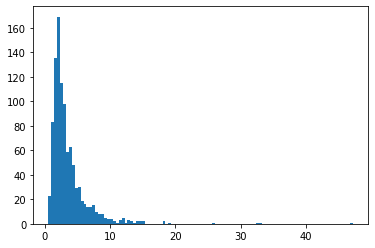

In [2]:
plt.hist(tfd.BetaQuotient(concentration1_numerator=5.,
                          concentration0_numerator=2.,
                          concentration1_denominator=3.,
                          concentration0_denominator=8.).sample(1_000, seed=(1, 23)),
         bins='auto');

### `DeterminantalPointProcess`

Distribution over subsets (represented as one-hot) of a given set. Samples follow a repulsivity property (probabilities are proportional to the volume spanned by vectors corresponding to the selected subset of points), which tends toward sampling diverse subsets. [Compare against i.i.d. Bernoulli samples.]

tfp.distributions.DeterminantalPointProcess("DeterminantalPointProcess", batch_shape=[4], event_shape=[256], dtype=int32)


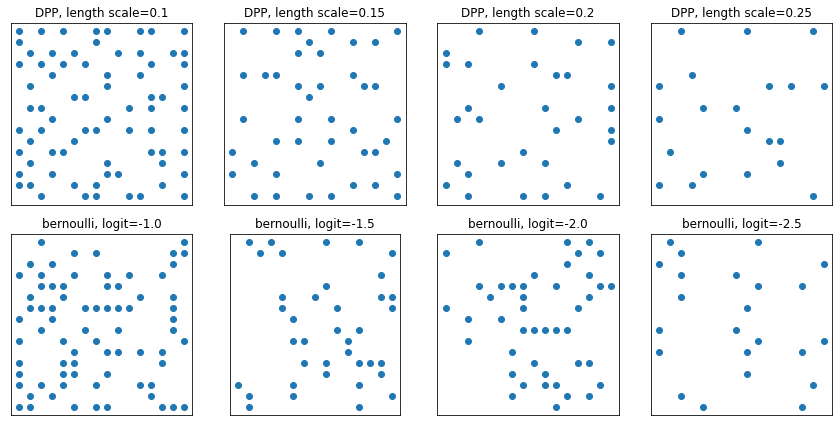

In [3]:
grid_size = 16
# Generate grid_size**2 pts on the unit square.
grid = np.arange(0, 1, 1./grid_size).astype(np.float32)
import itertools
points = np.array(list(itertools.product(grid, grid)))

# Create the kernel L that parameterizes the DPP.
kernel_amplitude = 2.
kernel_lengthscale = [.1, .15, .2, .25]  # Increasing length scale indicates more points are "nearby", tending toward smaller subsets.
kernel = tfpk.ExponentiatedQuadratic(kernel_amplitude, kernel_lengthscale)
kernel_matrix = kernel.matrix(points, points)

eigenvalues, eigenvectors = tf.linalg.eigh(kernel_matrix)
dpp = tfd.DeterminantalPointProcess(eigenvalues, eigenvectors)
print(dpp)

# The inner-most dimension of the result of `dpp.sample` is a multi-hot
# encoding of a subset of {1, ..., ground_set_size}.
# We will compare against a bernoulli distribution.
samps_dpp = dpp.sample(seed=(1, 2))  # 4 x grid_size**2
logits = tf.broadcast_to([[-1.], [-1.5], [-2], [-2.5]], [4, grid_size**2])
samps_bern = tfd.Bernoulli(logits=logits).sample(seed=(2, 3))

plt.figure(figsize=(12, 6))
for i, (samp, samp_bern) in enumerate(zip(samps_dpp, samps_bern)):
  plt.subplot(241 + i)
  plt.scatter(*points[np.where(samp)].T)
  plt.title(f'DPP, length scale={kernel_lengthscale[i]}')
  plt.xticks([])
  plt.yticks([])
  plt.gca().set_aspect(1.)
  plt.subplot(241 + i + 4)
  plt.scatter(*points[np.where(samp_bern)].T)
  plt.title(f'bernoulli, logit={logits[i,0]}')
  plt.xticks([])
  plt.yticks([])
  plt.gca().set_aspect(1.)

plt.tight_layout()
plt.show()

### `SigmoidBeta`

Log-odds of two gamma distributions. More numerically stable sample space than `Beta`.

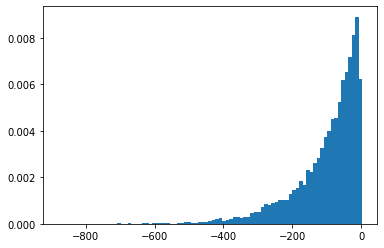

Old way, fractions non-finite:
0.4215
0.8624


In [4]:
plt.hist(tfd.SigmoidBeta(concentration1=.01, concentration0=2.).sample(10_000, seed=(1, 23)),
         bins='auto', density=True);
plt.show()

print('Old way, fractions non-finite:')
print(np.sum(~tf.math.is_finite(
    tfb.Invert(tfb.Sigmoid())(tfd.Beta(concentration1=.01, concentration0=2.)).sample(10_000, seed=(1, 23)))) / 10_000)
print(np.sum(~tf.math.is_finite(
    tfb.Invert(tfb.Sigmoid())(tfd.Beta(concentration1=2., concentration0=.01)).sample(10_000, seed=(2, 34)))) / 10_000)

### Zipf
Added JAX support.

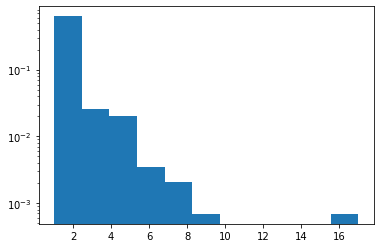

In [5]:
plt.hist(tfd.Zipf(3.).sample(1_000, seed=(12, 34)).numpy(), bins='auto', density=True, log=True);

### `NormalInverseGaussian`

Flexible parametric family that supports heavy tails, skewed, and vanilla Normal.

### `MatrixNormalLinearOperator`
Matrix Normal distribution.

In [6]:
# Initialize a single 2 x 3 Matrix Normal.
mu = [[1., 2, 3], [3., 4, 5]]
col_cov = [[ 0.36,  0.12,  0.06],
           [ 0.12,  0.29, -0.13],
           [ 0.06, -0.13,  0.26]]
scale_column = tf.linalg.LinearOperatorLowerTriangular(tf.linalg.cholesky(col_cov))
scale_row = tf.linalg.LinearOperatorDiag([0.9, 0.8])

mvn = tfd.MatrixNormalLinearOperator(loc=mu, scale_row=scale_row, scale_column=scale_column)
mvn.sample()

Instructions for updating:
Do not call `graph_parents`.


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1.2495145, 1.549366 , 3.2748342],
       [3.7330258, 4.3413105, 4.83423  ]], dtype=float32)>

### `MatrixStudentTLinearOperator`
Matrix T distribution.

In [7]:
mu = [[1., 2, 3], [3., 4, 5]]
col_cov = [[ 0.36,  0.12,  0.06],
           [ 0.12,  0.29, -0.13],
           [ 0.06, -0.13,  0.26]]
scale_column = tf.linalg.LinearOperatorLowerTriangular(tf.linalg.cholesky(col_cov))
scale_row = tf.linalg.LinearOperatorDiag([0.9, 0.8])

mvn = tfd.MatrixTLinearOperator(
    df=2.,
    loc=mu,
    scale_row=scale_row,
    scale_column=scale_column)
mvn.sample()

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1.6549466, 2.6708362, 2.8629923],
       [2.1222284, 3.6904747, 5.08014  ]], dtype=float32)>

## Distributions [software / wrappers]

### `Sharded`
Shards independent event portions of a distribution across multiple processors. Aggregates `log_prob` across devices, handles gradients in concert with `tfp.experimental.distribute.JointDistribution*`. Much more in the [Distributed Inference](https://www.tensorflow.org/probability/examples/Distributed_Inference_with_JAX) notebook.

In [8]:
strategy = tf.distribute.MirroredStrategy()

@tf.function
def sample_and_lp(seed):
  d = tfp.experimental.distribute.Sharded(tfd.Normal(0, 1))
  s = d.sample(seed=seed)
  return s, d.log_prob(s)

strategy.run(sample_and_lp, args=(tf.constant([12,34]),))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1').


(PerReplica:{
   0: <tf.Tensor: shape=(), dtype=float32, numpy=0.0051413667>,
   1: <tf.Tensor: shape=(), dtype=float32, numpy=-0.3393052>
 }, PerReplica:{
   0: <tf.Tensor: shape=(), dtype=float32, numpy=-1.8954543>,
   1: <tf.Tensor: shape=(), dtype=float32, numpy=-1.8954543>
 })

### `BatchBroadcast`

Implicitly broadcast the batch dimensions of an underlying distribution _with_ or _to_ a given batch shape.

In [9]:
underlying = tfd.MultivariateNormalDiag(tf.zeros([7, 1, 5]), tf.ones([5]))
print('underlying:', underlying)

d = tfd.BatchBroadcast(underlying, [8, 1, 6])
print('broadcast [7, 1] *with* [8, 1, 6]:', d)

try:
  tfd.BatchBroadcast(underlying, to_shape=[8, 1, 6])
except ValueError as e:
  print('broadcast [7, 1] *to* [8, 1, 6] is invalid:', e)

d = tfd.BatchBroadcast(underlying, to_shape=[8, 7, 6])
print('broadcast [7, 1] *to* [8, 7, 6]:', d)

underlying: tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[7, 1], event_shape=[5], dtype=float32)
broadcast [7, 1] *with* [8, 1, 6]: tfp.distributions.BatchBroadcast("BatchBroadcastMultivariateNormalDiag", batch_shape=[8, 7, 6], event_shape=[5], dtype=float32)
broadcast [7, 1] *to* [8, 1, 6] is invalid: Argument `to_shape` ([8 1 6]) is incompatible with underlying distribution batch shape ((7, 1)).
broadcast [7, 1] *to* [8, 7, 6]: tfp.distributions.BatchBroadcast("BatchBroadcastMultivariateNormalDiag", batch_shape=[8, 7, 6], event_shape=[5], dtype=float32)


### `Masked`

For single-program/multiple-data or sparse-as-masked-dense use-cases, a distribution that masks out the `log_prob` of invalid underlying distributions.

In [10]:
d = tfd.Masked(tfd.Normal(tf.zeros([7]), 1), 
               validity_mask=tf.sequence_mask([3, 4], 7))
print(d.log_prob(d.sample(seed=(1, 1))))

d = tfd.Masked(tfd.Normal(0, 1), 
               validity_mask=[False, True, False],
               safe_sample_fn=tfd.Distribution.mode)
print(d.log_prob(d.sample(seed=(2, 2))))

tf.Tensor(
[[-2.3054113 -1.8524303 -1.2220721  0.         0.         0.
   0.       ]
 [-1.118623  -1.1370811 -1.1574132 -5.884986   0.         0.
   0.       ]], shape=(2, 7), dtype=float32)
tf.Tensor([ 0.         -0.93683904  0.        ], shape=(3,), dtype=float32)


## Bijectors
- Bijectors
  - Add bijectors to mimic `tf.nest.flatten` (`tfb.tree_flatten`) and `tf.nest.pack_sequence_as` (`tfb.pack_sequence_as`).
  - Adds `tfp.experimental.bijectors.Sharded`
  - Remove deprecated `tfb.ScaleTrilL`.  Use `tfb.FillScaleTriL` instead.
  - Adds `cls.parameter_properties()` annotations for Bijectors.
  - Extend range `tfb.Power` to all reals for odd integer powers.
  - Infer the log-deg-jacobian of scalar bijectors using autodiff, if not otherwise specified.


### Restructuring bijectors

In [11]:
ex = (tf.constant(1.), dict(b=tf.constant(2.), c=tf.constant(3.)))
b = tfb.tree_flatten(ex)
print(b.forward(ex))
print(b.inverse(list(tf.constant([1., 2, 3]))))

b = tfb.pack_sequence_as(ex)
print(b.forward(list(tf.constant([1., 2, 3]))))
print(b.inverse(ex))

[<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=2.0>, <tf.Tensor: shape=(), dtype=float32, numpy=3.0>]
(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, {'b': <tf.Tensor: shape=(), dtype=float32, numpy=2.0>, 'c': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>})
(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, {'b': <tf.Tensor: shape=(), dtype=float32, numpy=2.0>, 'c': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>})
[<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=2.0>, <tf.Tensor: shape=(), dtype=float32, numpy=3.0>]


### `Sharded`
SPMD reduction in log-determinant. See `Sharded` in Distributions, below.

In [13]:
strategy = tf.distribute.MirroredStrategy()

def sample_lp_logdet(seed):
  d = tfd.TransformedDistribution(tfp.experimental.distribute.Sharded(tfd.Normal(0, 1), shard_axis_name='i'),
                                  tfp.experimental.bijectors.Sharded(tfb.Sigmoid(), shard_axis_name='i'))
  s = d.sample(seed=seed)
  return s, d.log_prob(s), d.bijector.inverse_log_det_jacobian(s)
strategy.run(sample_lp_logdet, (tf.constant([1, 2]),))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1').


(PerReplica:{
   0: <tf.Tensor: shape=(), dtype=float32, numpy=0.87746525>,
   1: <tf.Tensor: shape=(), dtype=float32, numpy=0.24580425>
 }, PerReplica:{
   0: <tf.Tensor: shape=(), dtype=float32, numpy=-0.48870325>,
   1: <tf.Tensor: shape=(), dtype=float32, numpy=-0.48870325>
 }, PerReplica:{
   0: <tf.Tensor: shape=(), dtype=float32, numpy=3.9154015>,
   1: <tf.Tensor: shape=(), dtype=float32, numpy=3.9154015>
 })

## VI

  - Adds `build_split_flow_surrogate_posterior` to `tfp.experimental.vi` to build structured VI surrogate posteriors from normalizing flows.
  - Adds `build_affine_surrogate_posterior` to `tfp.experimental.vi` for construction of ADVI surrogate posteriors from an event shape.
  - Adds `build_affine_surrogate_posterior_from_base_distribution` to `tfp.experimental.vi` to enable construction of ADVI surrogate posteriors with correlation structures induced by affine transformations.


### VI/MAP/MLE
  - Added convenience method `tfp.experimental.util.make_trainable(cls)` to create trainable instances of distributions and bijectors.

In [ ]:
d = tfp.experimental.util.make_trainable(tfd.Gamma)
print(d.trainable_variables)
print(d)

(<tf.Variable 'Gamma_trainable_variables/concentration:0' shape=() dtype=float32, numpy=1.0296053>, <tf.Variable 'Gamma_trainable_variables/log_rate:0' shape=() dtype=float32, numpy=-0.3465951>)
tfp.distributions.Gamma("Gamma", batch_shape=[], event_shape=[], dtype=float32)


## MCMC

  - MCMC diagnostics support arbitrary structures of states, not just lists.
  - `remc_thermodynamic_integrals` added to `tfp.experimental.mcmc`
  - Adds `tfp.experimental.mcmc.windowed_adaptive_hmc`
  - Adds an experimental API for initializing a Markov chain from a near-zero uniform distribution in unconstrained space. `tfp.experimental.mcmc.init_near_unconstrained_zero`
  - Adds an experimental utility for retrying Markov Chain initialization until an acceptable point is found. `tfp.experimental.mcmc.retry_init`
  - Shuffling experimental streaming MCMC API to slot into tfp.mcmc with a minimum of disruption.
  - Adds `ThinningKernel` to `experimental.mcmc`.
  - Adds `experimental.mcmc.run_kernel` driver as a candidate streaming-based replacement to `mcmc.sample_chain`



### `init_near_unconstrained_zero`, `retry_init`

In [73]:
@tfd.JointDistributionCoroutine
def model():
  Root = tfd.JointDistributionCoroutine.Root
  c0 = yield Root(tfd.Gamma(2, 2, name='c0'))
  c1 = yield Root(tfd.Gamma(2, 2, name='c1'))
  counts = yield tfd.Sample(tfd.BetaBinomial(23, c1, c0), 10, name='counts')
jd = model.experimental_pin(counts=model.sample(seed=[20, 30]).counts)

init_dist = tfp.experimental.mcmc.init_near_unconstrained_zero(jd)
print(init_dist)

tfp.experimental.mcmc.retry_init(init_dist.sample, jd.unnormalized_log_prob)

tfp.distributions.TransformedDistribution("default_joint_bijectorrestructureJointDistributionSequential", batch_shape=StructTuple(
  c0=[],
  c1=[]
), event_shape=StructTuple(
  c0=[],
  c1=[]
), dtype=StructTuple(
  c0=float32,
  c1=float32
))


StructTuple(
  c0=<tf.Tensor: shape=(), dtype=float32, numpy=1.7879653>,
  c1=<tf.Tensor: shape=(), dtype=float32, numpy=0.34548905>
)

### Windowed adaptive HMC and NUTS samplers

StructTuple(
  c0=<tf.Tensor: shape=(), dtype=float32, numpy=0.7161876>,
  c1=<tf.Tensor: shape=(), dtype=float32, numpy=1.7696666>,
  counts=<tf.Tensor: shape=(10,), dtype=float32, numpy=array([ 6., 10., 23.,  7.,  2., 20., 14., 16., 22., 17.], dtype=float32)>
)
StructTuple(
  c0=<tf.Tensor: shape=(), dtype=float32, numpy=0.7161876>,
  c1=<tf.Tensor: shape=(), dtype=float32, numpy=1.7696666>,
  counts=<tf.Tensor: shape=(250,), dtype=float32, numpy=
    array([ 6., 10., 23.,  7.,  2., 20., 14., 16., 22., 17., 22., 21.,  6.,
           21., 12., 22., 23., 16., 18., 21., 16., 17., 17., 16., 21., 14.,
           23., 15., 10., 19.,  8., 23., 23., 14.,  1., 23., 16., 22., 20.,
           20., 22., 15., 16., 20., 20., 21., 23., 22., 21., 15., 18., 23.,
           12., 16., 19., 23., 18.,  5., 22., 22., 22., 18., 12., 17., 17.,
           16.,  8., 22., 20., 23.,  3., 12., 14., 18.,  7., 19., 19.,  9.,
           10., 23., 14., 22., 22., 21., 13., 23., 14., 23., 10., 17., 23.,
           17.

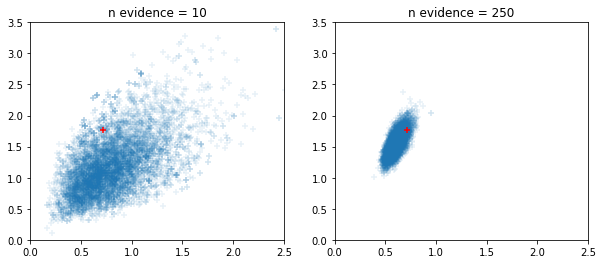

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, n_evidence in enumerate((10, 250)):
  ax[i].set_title(f'n evidence = {n_evidence}')
  ax[i].set_xlim(0, 2.5); ax[i].set_ylim(0, 3.5)
  @tfd.JointDistributionCoroutine
  def model():
    Root = tfd.JointDistributionCoroutine.Root
    c0 = yield Root(tfd.Gamma(2, 2, name='c0'))
    c1 = yield Root(tfd.Gamma(2, 2, name='c1'))
    counts = yield tfd.Sample(tfd.BetaBinomial(23, c1, c0), n_evidence, name='counts')
  s = model.sample(seed=[20, 30])
  print(s)
  jd = model.experimental_pin(counts=s.counts)
  states, trace = tf.function(tfp.experimental.mcmc.windowed_adaptive_hmc)(
      100, jd, num_leapfrog_steps=5, seed=[100, 200])
  ax[i].scatter(states.c0.numpy().reshape(-1), states.c1.numpy().reshape(-1), 
                marker='+', alpha=.1)
  ax[i].scatter(s.c0, s.c1, marker='+', color='r')

## Math, stats


- Math/linalg
  - Add `tfp.math.trapz` for trapezoidal integration.
  - Add `tfp.math.log_bessel_kve`.
  - Add `no_pivot_ldl` to `experimental.linalg`.
  - Add `marginal_fn` argument to `GaussianProcess` (see `no_pivot_ldl`).
  - Added `tfp.math.atan_difference(x, y)`
  - Add `tfp.math.erfcx`, `tfp.math.logerfc` and `tfp.math.logerfcx`
  - Add `tfp.math.dawsn` for Dawson's Integral.
  - Add `tfp.math.igammaincinv`, `tfp.math.igammacinv`.
  - Add `tfp.math.sqrt1pm1`.
  - Add `LogitNormal.stddev_approx` and `LogitNormal.variance_approx`
  - Add `tfp.math.owens_t` for the Owen's T function.
  - Add `bracket_root` method to automatically initialize bounds for a root search.
  - Add Chandrupatla's method for finding roots of scalar functions.

- Stats
  - `tfp.stats.windowed_mean` efficiently computes windowed means.
  - `tfp.stats.windowed_variance` efficiently and accurately computes windowed variances.
  - `tfp.stats.cumulative_variance` efficiently and accurately computes cumulative variances.
  - `RunningCovariance` and friends can now be initialized from an example Tensor, not just from explicit shape and dtype.
  - Cleaner API for `RunningCentralMoments`, `RunningMean`, `RunningPotentialScaleReduction`.


### Owen's T, Erfcx, Logerfc, Logerfcx, Dawson functions

In [ ]:
# Owen's T gives the probability that X > h, 0 < Y < a * X. Let's check that
# with random sampling.
h = np.array([1., 2.]).astype(np.float32)
a = np.array([10., 11.5]).astype(np.float32)
probs = tfp.math.owens_t(h, a)

x = tfd.Normal(0., 1.).sample(int(1e5), seed=(6, 245)).numpy()
y = tfd.Normal(0., 1.).sample(int(1e5), seed=(7, 245)).numpy()

true_values = (
    (x[..., np.newaxis] > h) &
    (0. < y[..., np.newaxis]) &
    (y[..., np.newaxis] < a * x[..., np.newaxis]))

print('Calculated values: {}'.format(
    np.count_nonzero(true_values, axis=0) / 1e5))

print('Expected values: {}'.format(probs))

Calculated values: [0.07896 0.01134]
Expected values: [0.07932763 0.01137507]


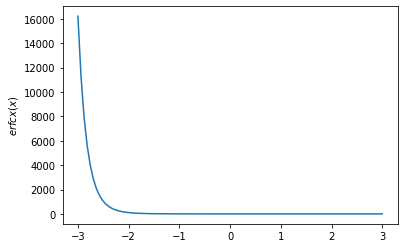

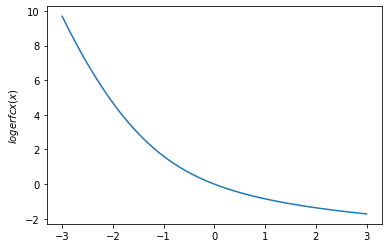

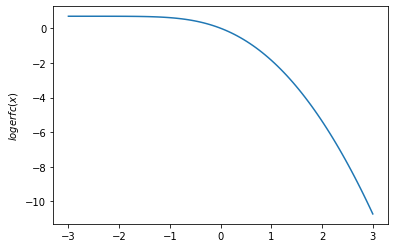

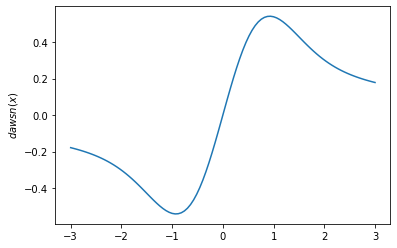

In [ ]:
x = np.linspace(-3., 3., 100)
plt.plot(x, tfp.math.erfcx(x))
plt.ylabel('$erfcx(x)$')
plt.show()

plt.plot(x, tfp.math.logerfcx(x))
plt.ylabel('$logerfcx(x)$')
plt.show()

plt.plot(x, tfp.math.logerfc(x))
plt.ylabel('$logerfc(x)$')
plt.show()

plt.plot(x, tfp.math.dawsn(x))
plt.ylabel('$dawsn(x)$')
plt.show()

### igammainv /  igammacinv

In [ ]:
# Igammainv and Igammacinv are inverses to Igamma and Igammac

x = np.linspace(1., 10., 10)
y = tf.math.igamma(0.3, x)
x_prime = tfp.math.igammainv(0.3, y)
print('x: {}'.format(x))
print('igammainv(igamma(a, x)):\n {}'.format(x_prime))

y = tf.math.igammac(0.3, x)
x_prime = tfp.math.igammacinv(0.3, y)

print('\n')
print('x: {}'.format(x))
print('igammacinv(igammac(a, x)):\n {}'.format(x_prime))

x: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
igammainv(igamma(a, x)):
 [1.        1.9999992 3.000003  4.0000024 5.0000257 5.999887  7.0002484
 7.999243  8.99872   9.994673 ]


x: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
igammacinv(igammac(a, x)):
 [1.       2.       3.       4.       5.       6.       7.       8.000001
 9.       9.999999]


### log-kve

Text(0.5, 1.0, 'Log(BesselKve(v, x)')

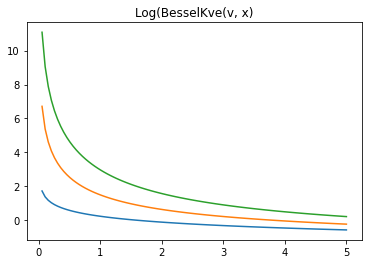

In [ ]:
x = np.linspace(0., 5., 100)
for v in [0.5, 2., 3]:
  plt.plot(x, tfp.math.log_bessel_kve(v, x).numpy())

plt.title('Log(BesselKve(v, x)')

## Other


- STS
  - Speed up STS forecasting and decomposition using internal `tf.function` wrapping.
  - Add option to speed up filtering in `LinearGaussianSSM` when only the final step's results are required.
  - Variational Inference with joint distributions: [example notebook with the Radon model](https://www.tensorflow.org/probability/examples/Variational_Inference_and_Joint_Distributions).
  - Add experimental support for transforming any distribution into a preconditioning bijector.

- Adds `tfp.random.sanitize_seed`.
- Adds `tfp.random.spherical_uniform`.



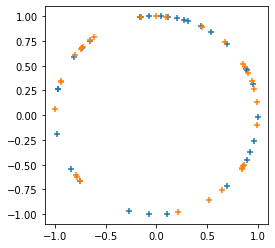

In [64]:
plt.figure(figsize=(4, 4))
seed = tfp.random.sanitize_seed(123)
seed1, seed2 = tfp.random.split_seed(seed)
samps = tfp.random.spherical_uniform([30], dimension=2, seed=seed1)
plt.scatter(*samps.numpy().T, marker='+')
samps = tfp.random.spherical_uniform([30], dimension=2, seed=seed2)
plt.scatter(*samps.numpy().T, marker='+');